In [18]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [21]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()

In [22]:
# reflect an existing database into a new model
Base.prepare(autoload_with=engine)
# reflect the tables


In [23]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
Station = Base.classes.station

In [25]:
# Save references to each table
Measurement = Base.classes.measurement


In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
#test the dictionaries for info

# Measurement columns = id, station, prcp, date, tobs
measure_test = session.query(Measurement).first()
measure_test.__dict__

#Station columns = id, name, latitude, elevation, station, longitude
station_test = session.query(Station).first()
station_test.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fc7e4ada050>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [28]:
# Find the most recent date in the data set.
last_date = session.query(func.max(Measurement.date)).scalar()
print(last_date)

2017-08-23


In [29]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most RECENT (Confused about this defenition) data point in the database. 
# last_date

# Calculate the date one year from the last date in data set.
previous_year = session.query(func.date(func.max(Measurement.date), '-365 days')).scalar()
print(previous_year)

# Perform a query to retrieve the data and precipitation scores
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= previous_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

rain_date = [rain[0] for date in rain]
percp = [rain[1] for prcp in rain]

2016-08-23


In [30]:

rain_df = pd.DataFrame(rain, columns=['rain_date', 'percp'])

# Sort the dataframe by date
rain_df.set_index('rain_date')

rain_df.head()


,rain_date,percp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


Text(0, 0.5, 'Inches')

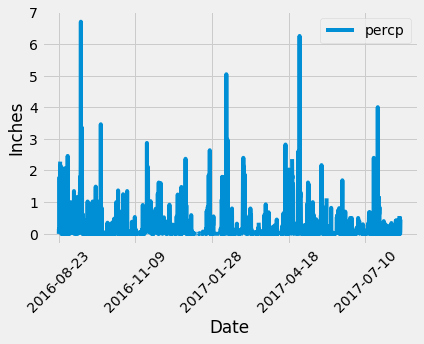

In [41]:
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot(x='rain_date', y='percp', rot=45)
plt.xlabel('Date')
plt.ylabel('Inches')


There are a few outliers, but percipitation is generally steady and consistent with no signs of drought. 


In [32]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,percp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


By using this describe method, we can observe that the average rainfall is close to .2 inches, and that most measurements fall in the 75% quadrant of totals. 

# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station).count()
station_count

9

In [34]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
# most active station id = 'USC00519281'

active_station = 'USC00519281'
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
climate_anly = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                             filter(Measurement.station == active_station).all()
climate_anly

[(54.0, 85.0, 71.66378066378067)]

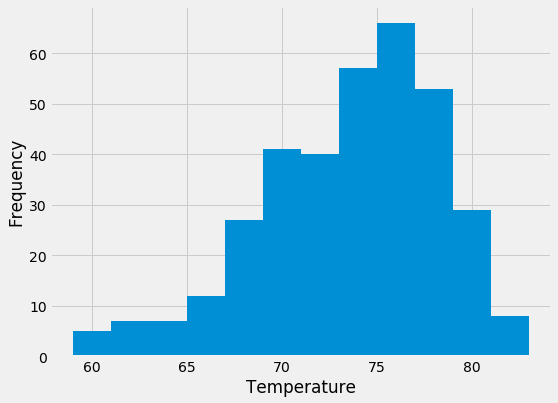

In [57]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

active_data = session.query(Measurement.tobs).filter((Measurement.station == active_station), (Measurement.date >= previous_year)).all()

temps = list(np.ravel(active_data))

fig, ax = plt.subplots(figsize=(8,6))
ax.hist(temps, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


# Close session

In [58]:
# Close Session
session.close()